## Chunking

Having the text parsed from the documents lets chunk it into smaller pieces. We are going to also extract from the funds the risk level to be added to the metadata.

In [1]:
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core import Document
from pathlib import Path


def process_markdown_folder(folder_path: str):
    """
    Process all markdown files in a folder and chunk them by headers.
    
    Args:
        folder_path: Path to the folder containing markdown files
        
    Returns:
        Dictionary mapping file names to their chunked nodes
    """
    
    folder = Path(folder_path)
    
    # Get all markdown files in the folder
    markdown_files = list(folder.glob("*.md"))
    
    if not markdown_files:
        print(f"No markdown files found in {folder_path}")
        return {}
    
    print(f"Found {len(markdown_files)} markdown files")
    
    # Create the markdown parser
    markdown_parser = MarkdownNodeParser()
    
    # Dictionary to store results
    all_nodes = {}

    for md_file in markdown_files:

        print(f"\nProcessing: {md_file.name}")
        
        # Read the markdown content
        with open(md_file, "r", encoding="utf-8") as f:
            markdown_string = f.read()
        
        # Create a LlamaIndex Document
        doc = Document(text=markdown_string, metadata={"filename": md_file.name})
        
        # Get the nodes (chunks) from the document
        nodes = markdown_parser.get_nodes_from_documents([doc])
        
        # Store the nodes
        all_nodes[md_file.name] = nodes
        
        print(f"  Created {len(nodes)} chunks from {md_file.name}")
    
    return all_nodes

etfNodes = process_markdown_folder("./etf_processed")

fundNodes = process_markdown_folder("./fund_processed")


for filename, nodes in etfNodes.items():
    print(f"\n{'='*60}")
    print(f"File: {filename}")
    print(f"Total chunks: {len(nodes)}")
    print(f"{'='*60}")
    
    for i, node in enumerate(nodes):
        node.metadata["type"] = "ETF FactSheet"


for filename, nodes in fundNodes.items():
    print(f"\n{'='*60}")
    print(f"File: {filename}")
    print(f"Total chunks: {len(nodes)}")
    print(f"{'='*60}")
    
    # --- Step 1: Find the risk level for the entire file first ---
    file_risk_level = None  # Default to None
    for node in nodes:
        if "## Risk Level" in node.text:
            try:
                # Extract the risk level number from the node's text
                risk_value = int(node.text.strip()[-1])
                file_risk_level = risk_value
                print(f"--- Found Risk Level for '{filename}': {file_risk_level} ---")
                break 
            except (ValueError, IndexError):
                print(f"--- Warning: Could not parse risk level from text: '{node.text}' ---")
    
    # --- Step 2: Now, iterate through all nodes again to apply the metadata ---
    for node in nodes:
        
        node.metadata["type"] = "Fund FactSheet"
        if file_risk_level is not None:
            node.metadata["risk_level"] = file_risk_level
        print(node.metadata)



Found 20 markdown files

Processing: Financials_ETF_factSheet.md
  Created 12 chunks from Financials_ETF_factSheet.md

Processing: Total_World_Bond_ETF_factSheet.md
  Created 14 chunks from Total_World_Bond_ETF_factSheet.md

Processing: ESG_U.S._Corporate_Bond_ETF_factSheet.md
  Created 15 chunks from ESG_U.S._Corporate_Bond_ETF_factSheet.md

Processing: FTSE_Pacific_ETF_factSheet.md
  Created 13 chunks from FTSE_Pacific_ETF_factSheet.md

Processing: Consumer_Discretionary_ETF_factSheet.md
  Created 12 chunks from Consumer_Discretionary_ETF_factSheet.md

Processing: FTSE_Europe_ETF_factSheet.md
  Created 13 chunks from FTSE_Europe_ETF_factSheet.md

Processing: International_High_Dividend_Yield_ETF_factSheet.md
  Created 13 chunks from International_High_Dividend_Yield_ETF_factSheet.md

Processing: U.S._Minimum_Volatility_ETF_factSheet.md
  Created 12 chunks from U.S._Minimum_Volatility_ETF_factSheet.md

Processing: S&P_Mid-Cap_400_Value_ETF_factSheet.md
  Created 12 chunks from S&P_Mid

It is also very useful in each of the chunks to add in the title of the section the name of the fund or etf so that the semantic search can work better.

20

File: Financials_ETF_factSheet.md
Total chunks: 12
Fund name: Financials ETF
Chunk 2: Financials ETF
## Investment approach

- Seeks to track the performance of the MSCI US Investable Market Index (IMI)/Financials  25/50.
- Multicapitalization  equity in the financials sector.
- Passively managed, uses full-replication  strategy when possible.
- If regulatory constraints prevent full replication, uses sampling strategy to approximate the index's key characteristics.
- Fund remains fully invested.
- Low expenses minimize net tracking error.
Chunk 3: Financials ETF
## About the benchmark

- The MSCI US Investable Market Index (IMI)/Financials  25/50 includes stocks of U.S. companies within the financials sector.
- The sector is made up of companies involved in activities such as banking, mortgage finance, consumer finance, specialized finance, investment banking and brokerage, asset management and custody, corporate lending, insurance, and financial investment.
- Uses GICS methodolog
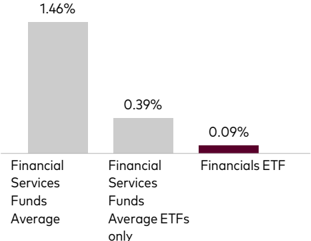
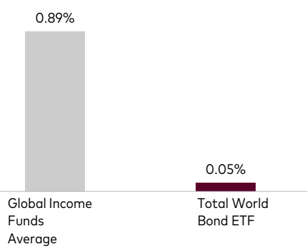
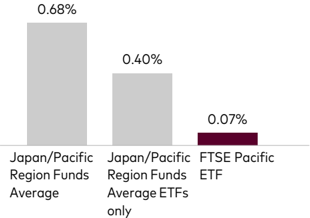
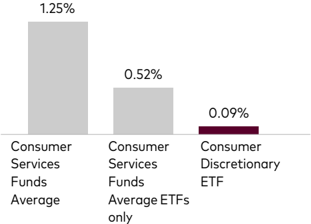
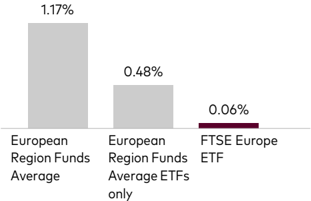
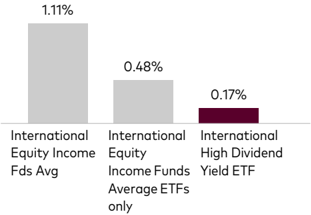
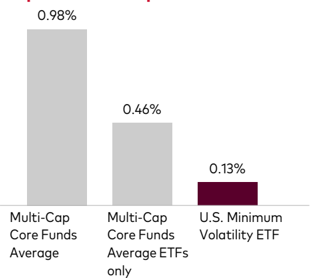
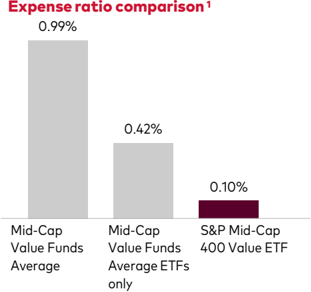
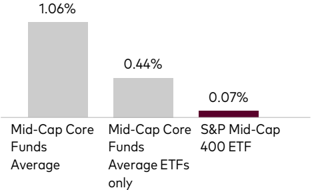
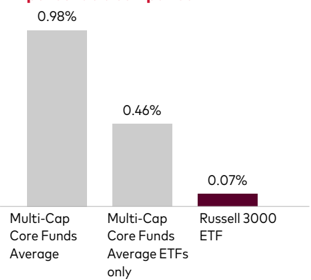
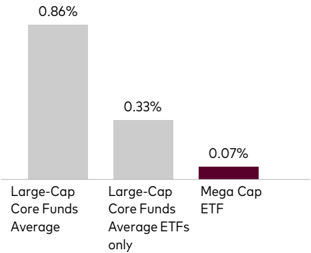
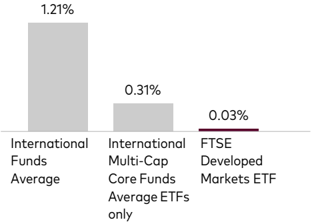
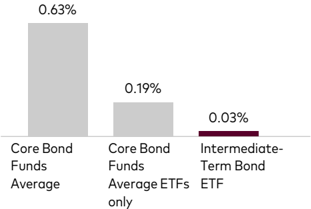
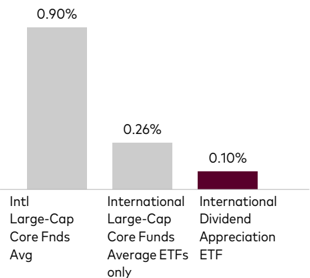
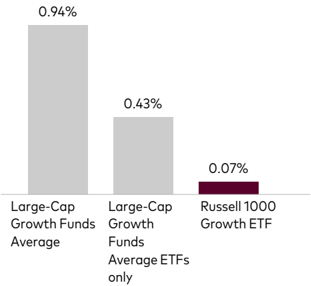
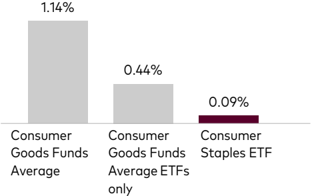
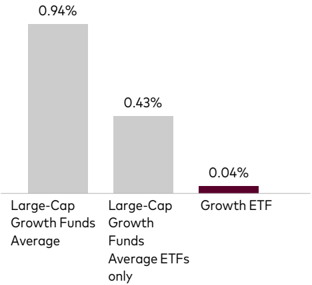
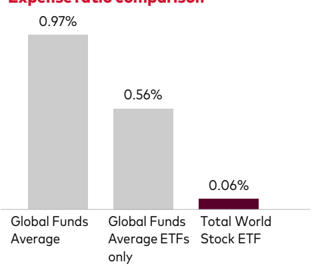
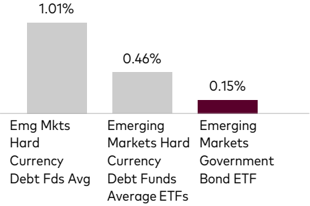

In [ ]:

import re

def extract_etf_name(first_chunk_text):
    """
    Extract fund name from the first chunk of each document.
    
    Args:
        first_chunk_text: Text content from the first chunk
        
    Returns:
        str: Extracted fund name or None if not found
    """
    
    pattern1 = r'##\s+Vanguard\s+(?:®\s+)?(?:Vanguard\s+)?(.*?)\s+(?:ETF)?\s+\|\s+[A-Z]+'
    
    match = re.search(pattern1, first_chunk_text)
    if match:

        etf_name = match.group(1).strip()
        if not etf_name.endswith('ETF'):
            etf_name += ' ETF'

        return etf_name
    
    return None


print(len(etfNodes.items()))
names = []
for filename, nodes in etfNodes.items():
    print(f"\n{'='*60}")
    print(f"File: {filename}")
    print(f"Total chunks: {len(nodes)}")
    print(f"{'='*60}")
    
    for i, node in enumerate(nodes):
        if i == 0:
            name = extract_etf_name(node.text)
            node.metadata['name'] = name
            print(f"Fund name: {name}")
        else:
            new_text = f"{name}\n{node.text}"
            node.text = new_text
            print(f"Chunk {i+1}: {new_text}")

print(len(names))

20

File: Small-Cap_Value_Index_Fund_factSheet.md
Total chunks: 16
Fund name: Small-Cap Value Index Fund
Chunk 2: Small-Cap Value Index Fund
## Fund facts

| Risk level Low High   | Total net assets   | Expense ratio as of 04/29/25   | Ticker symbol   | Turnover rate   | Inception date   |   Fund number |
|-----------------------|--------------------|--------------------------------|-----------------|-----------------|------------------|---------------|
| 1 2 3 4 5             | $89MM              | 0.19%                          | VISVX           | 15.8%           | 05/21/98         |          0860 |
Chunk 3: Small-Cap Value Index Fund
## Investment objective

Vanguard Small-Cap Value Index Fund seeks to track the performance of a benchmark index that measures the investment return of small-capitalization value stocks.
Chunk 4: Small-Cap Value Index Fund
## Investment strategy

The fund employs an indexing investment approach designed to track the performance of the the CRSP US Small 
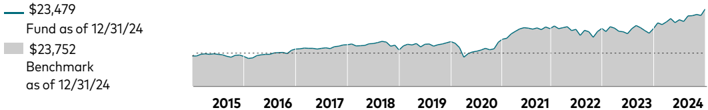
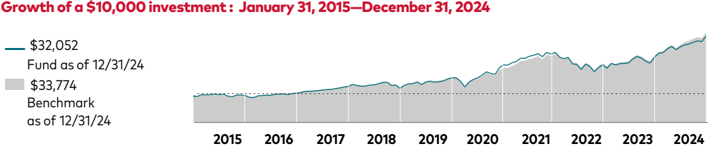
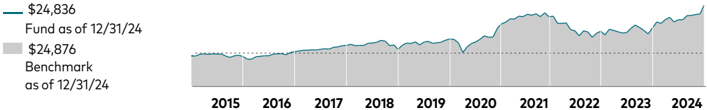
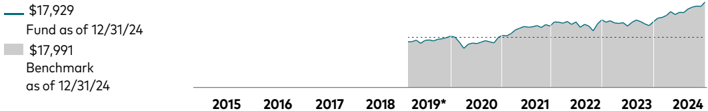
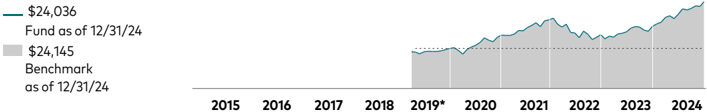
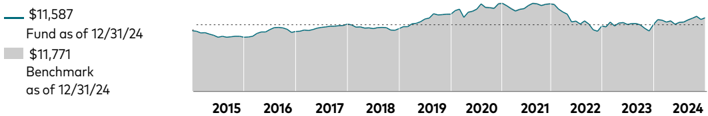
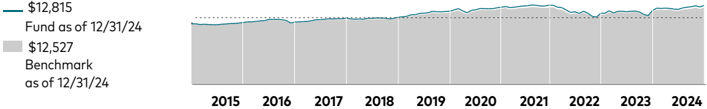
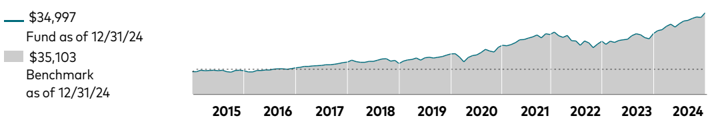
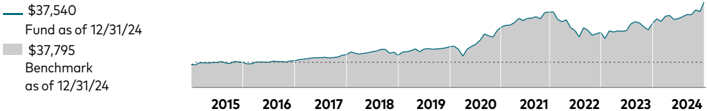
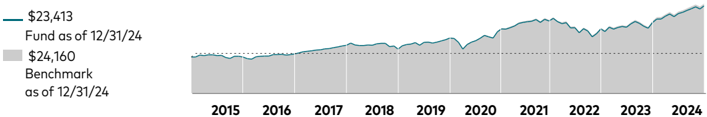
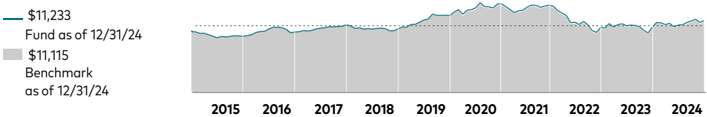
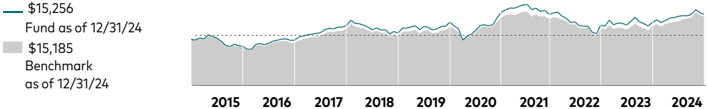
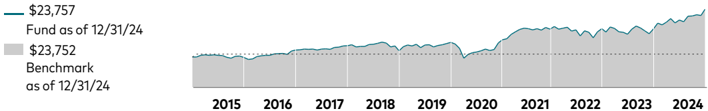
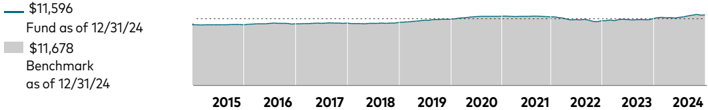
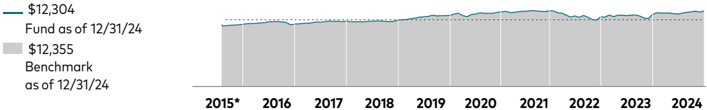
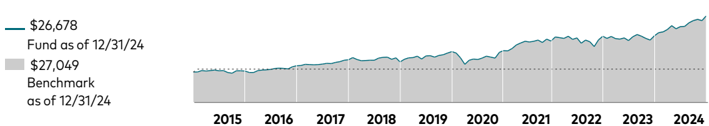
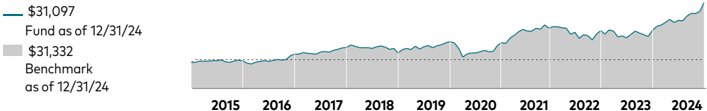
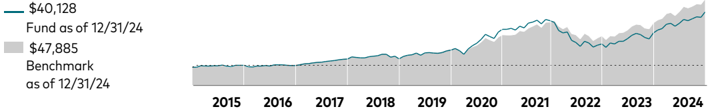
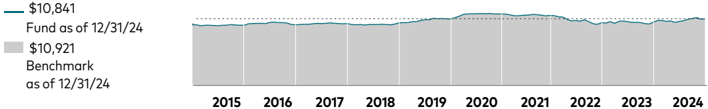

In [ ]:

import re

def extract_fund_name(first_chunk_text):
    """
    Extract fund name from the first chunk of each document.
    """

    fund_name = re.search(r'Vanguard(.+?Fund)', first_chunk_text).group(1).strip()

    return fund_name

print(len(fundNodes.items()))
names = []
for filename, nodes in fundNodes.items():
    print(f"\n{'='*60}")
    print(f"File: {filename}")
    print(f"Total chunks: {len(nodes)}")
    print(f"{'='*60}")
    
    for i, node in enumerate(nodes):
        if i == 0:
            name = extract_fund_name(node.text)
            names.append(name)
            node.metadata['name'] = name
            print(f"Fund name: {name}")
        else:
            new_text = f"{name}\n{node.text}"
            node.metadata['name'] = name
            node.text = new_text
            print(f"Chunk {i+1}: {new_text}")

print(len(names))
for name in names:
    print(name)

## VanguardSmall-Cap Value Index Fund

Domestic stock fund | Investor Shares
Small-Cap Value Index Fund
## Fund facts

| Risk level Low High   | Total net assets   | Expense ratio as of 04/29/25   | Ticker symbol   | Turnover rate   | Inception date   |   Fund number |
|-----------------------|--------------------|--------------------------------|-----------------|-----------------|------------------|---------------|
| 1 2 3 4 5             | $89MM              | 0.19%                          | VISVX           | 15.8%           | 05/21/98         |          0860 |
Small-Cap Value Index Fund
## Investment objective

Vanguard Small-Cap Value Index Fund seeks to track the performance of a benchmark index that measures the investment return of small-capitalization value stocks.
Small-Cap Value Index Fund
## Investment strategy

The fund employs an indexing investment approach designed to track the performance of the the CRSP US Small Cap Value Index, a broadly diversified index of value s
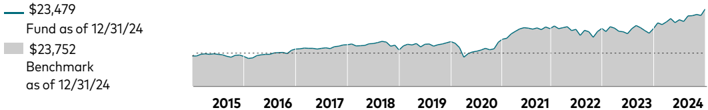
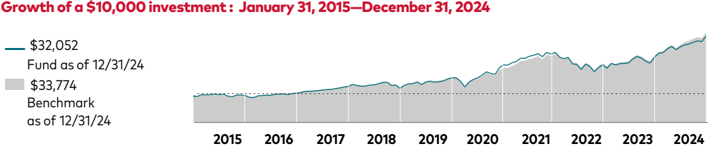
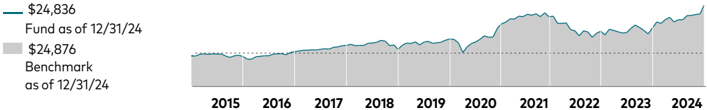
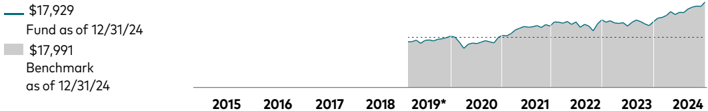
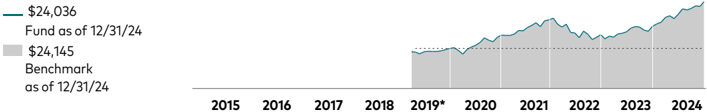
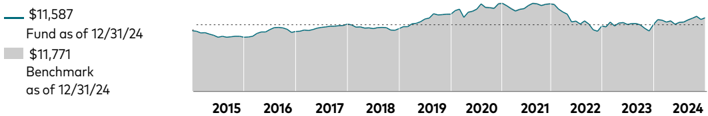
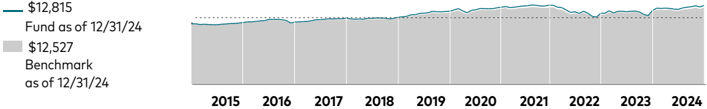
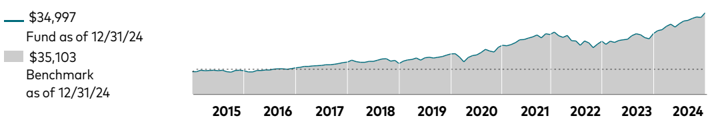
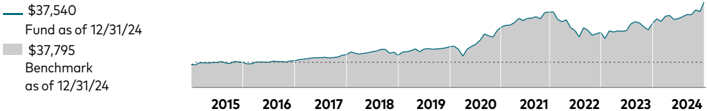
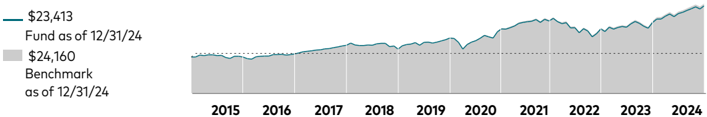
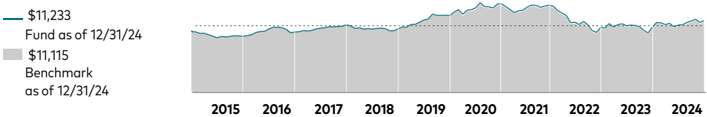
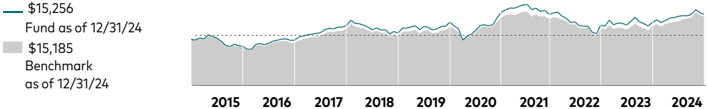
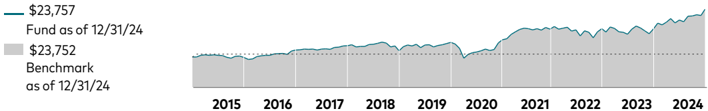
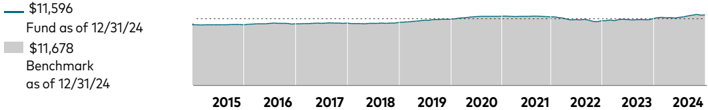
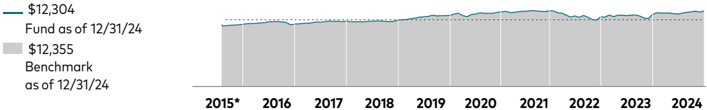
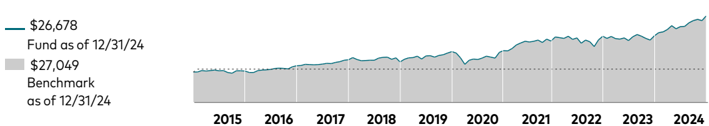
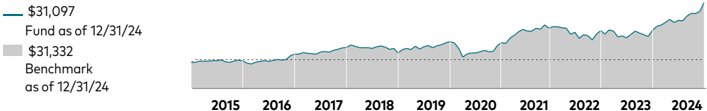
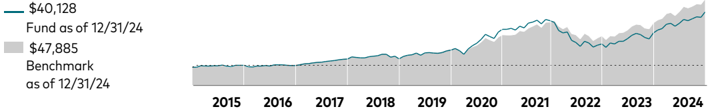
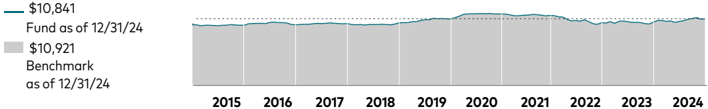
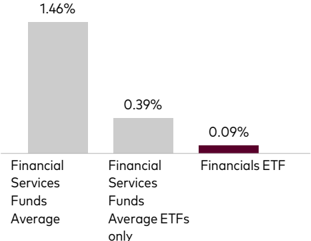
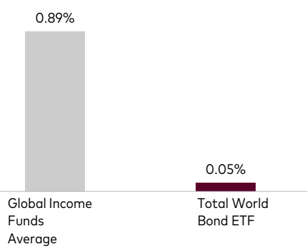
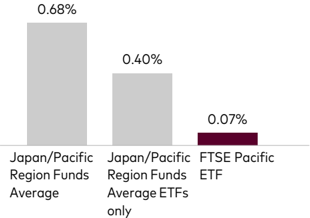
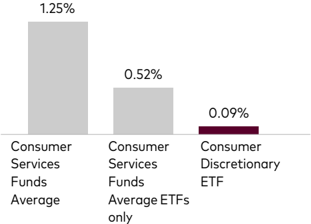
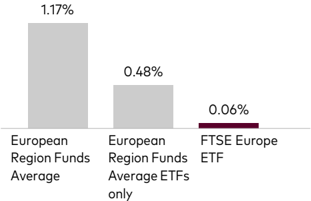
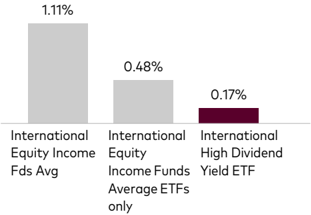
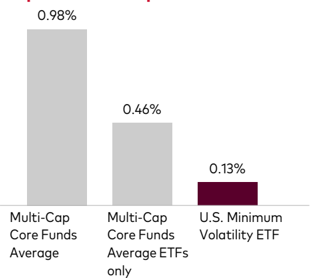
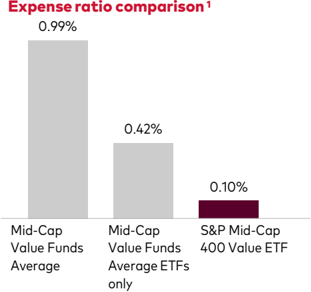
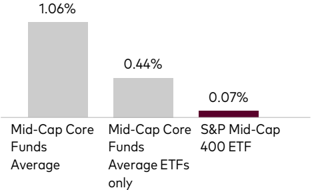
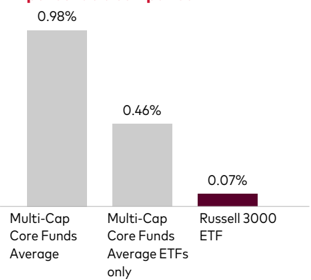
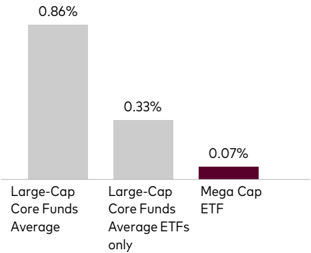
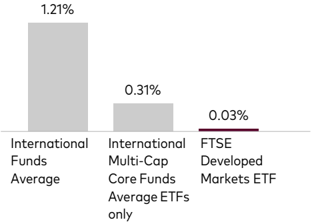
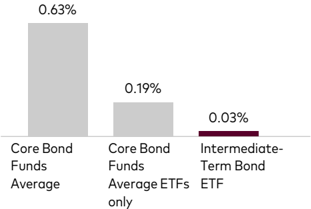
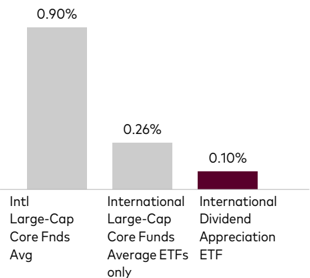
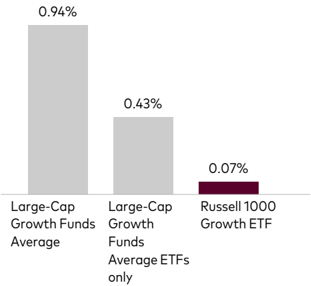
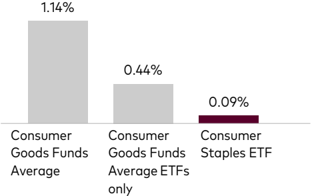
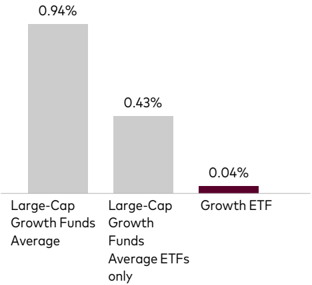
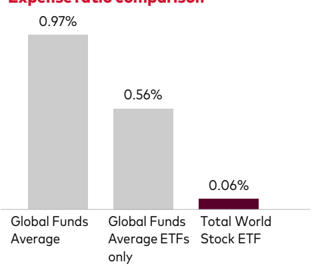
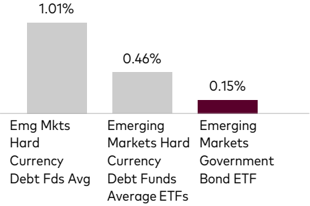

In [4]:
# 2. Extract combined_text from processed chunks
fund_chunks = fundNodes
etf_chunks = etfNodes

texts_funds = []
texts_etf = []
for filename, nodes in fund_chunks.items():
    for node in nodes:
        texts_funds.append(node.text)
        print(node.text)

for filename, nodes in etf_chunks.items():
    for node in nodes:
        texts_etf.append(node.text)
        print(node.text)

funds_data = []
for filename, nodes in fund_chunks.items():
    for node in nodes:
        funds_data.append({
            "text": node.text,
            "filename": filename,
            "embedding": None,
            "metadata": node.metadata 
        })
etf_data = []
for filename, nodes in etf_chunks.items():
    for node in nodes:
        etf_data.append({
            "text": node.text,
            "filename": filename,
            "embedding": None,
            "metadata": node.metadata 
        })



## Embeddings

In the next cell we can see the structure of the metadata and the objects that are going to be inserted in the Qdrant database after generating the embeddings.

In [5]:
funds_data[2]

{'text': 'Small-Cap Value Index Fund\n## Investment objective\n\nVanguard Small-Cap Value Index Fund seeks to track the performance of a benchmark index that measures the investment return of small-capitalization value stocks.',
 'filename': 'Small-Cap_Value_Index_Fund_factSheet.md',
 'embedding': None,
 'metadata': {'filename': 'Small-Cap_Value_Index_Fund_factSheet.md',
  'header_path': '/',
  'type': 'Fund FactSheet',
  'risk_level': 5,
  'name': 'Small-Cap Value Index Fund'}}

I am going to use the bge-base embedding model which uses about 1gb VRAM and which i have seen works well in the whole RAG pipeline with the other LLMS used during the pipelin. It achieves almost the same results as the bge-large model.

In [6]:

import sys
sys.path.append('../src/')
from simple_rag.embeddings.embedding import EmbedData

# 1. Initialize the EmbedData class with BGE model
model_name = "BAAI/bge-base-en-v1.5"
batch_size = 64

print("Initializing BGE embedding model...")
embed_model = EmbedData(model_name=model_name, batch_size=batch_size)
print("Model loaded successfully.")


print(f"📊 Total documents to embed: {len(texts_funds)}")

# 3. Embed the documents
print("\n🔄 Generating embeddings...")
fund_vectors = embed_model.embed(texts_funds)

etf_vectors = embed_model.embed(texts_etf)

for vector, data in zip(fund_vectors, funds_data):
    data["embedding"] = vector

for vector, data in zip(etf_vectors, etf_data):
    data["embedding"] = vector


print(etf_data[0])



Initializing BGE embedding model...
Model loaded successfully.
📊 Total documents to embed: 314

🔄 Generating embeddings...


Embedding data in batches: 5it [00:08,  1.71s/it]                       
Embedding data in batches: 4it [00:06,  1.56s/it]                       

{'text': '## Vanguard Financials ETF    |  VFH\n\nAs of June 30, 2025', 'filename': 'Financials_ETF_factSheet.md', 'embedding': [0.049387674778699875, -0.027086105197668076, 0.0789044052362442, 0.053989049047231674, 0.028693145141005516, -0.011067511513829231, 0.07928285002708435, 0.02972843125462532, 0.005603090859949589, -0.05586198717355728, 0.006291730795055628, 0.030524680390954018, -0.01938406564295292, 0.01758149079978466, -0.009120180271565914, 0.03444893658161163, 0.02305120974779129, 0.01263486873358488, 0.013221599161624908, -0.045981209725141525, -0.04249143972992897, 0.00478392792865634, 0.09252285957336426, 0.030363092198967934, 0.005130165256559849, 0.0350683368742466, 0.014622779563069344, 0.0037878064904361963, -0.03751089423894882, 0.0180777907371521, 0.04866316542029381, -0.0008113379590213299, -0.02846122346818447, 0.014108146540820599, -0.022363340482115746, -0.02785489335656166, 0.008272127248346806, -0.024572322145104408, 0.00011575123789953068, 0.027604304254055

In [7]:
etf_data_qdrant = []
for dict in etf_data:
    payload = dict.copy()
    # Use .pop() to remove the 'embedding' key and assign its value to a variable
    embedding_vector = payload.pop('embedding')

# Create the final dictionary in the desired format for Qdrant
    data = {
        'vector': embedding_vector,
        'payload': payload
    }
    etf_data_qdrant.append(data)

print(etf_data_qdrant[0])


fund_data_qdrant = []
for dict in funds_data:
    payload = dict.copy()
    # Use .pop() to remove the 'embedding' key and assign its value to a variable
    embedding_vector = payload.pop('embedding')

# Create the final dictionary in the desired format for Qdrant
    data = {
        'vector': embedding_vector,
        'payload': payload
    }
    fund_data_qdrant.append(data)

print(fund_data_qdrant[0])

{'vector': [0.049387674778699875, -0.027086105197668076, 0.0789044052362442, 0.053989049047231674, 0.028693145141005516, -0.011067511513829231, 0.07928285002708435, 0.02972843125462532, 0.005603090859949589, -0.05586198717355728, 0.006291730795055628, 0.030524680390954018, -0.01938406564295292, 0.01758149079978466, -0.009120180271565914, 0.03444893658161163, 0.02305120974779129, 0.01263486873358488, 0.013221599161624908, -0.045981209725141525, -0.04249143972992897, 0.00478392792865634, 0.09252285957336426, 0.030363092198967934, 0.005130165256559849, 0.0350683368742466, 0.014622779563069344, 0.0037878064904361963, -0.03751089423894882, 0.0180777907371521, 0.04866316542029381, -0.0008113379590213299, -0.02846122346818447, 0.014108146540820599, -0.022363340482115746, -0.02785489335656166, 0.008272127248346806, -0.024572322145104408, 0.00011575123789953068, 0.027604304254055023, -0.06778044998645782, -0.024793587625026703, 0.039304014295339584, 0.006379290018230677, 0.005028515122830868, -

Created the chunks and formatted to be suitable for the Qdrant database the next step is to create the database and add the chunks to it.

## Vector Database

In [8]:
import subprocess
command = "docker run -p 6333:6333 -p 6334:6334 \
    -v $(pwd)/qdrant_storage:/qdrant/storage:z \
        qdrant/qdrant"

subprocess.Popen(command, shell=True)

<Popen: returncode: None args: 'docker run -p 6333:6333 -p 6334:6334     -v ...>

Here I create the database instance with the following configuration:

- I use Qdrant because of its fast performance and scalability and the fact that it is open source.
- Vector size is 768 which is the default size for the bge-base model.
- gRPC (Google Remote Procedure Call) which is faster that  HTTP.
- No indexing threshold in the beginning to reduce the time of ingestion.
- After the ingestion I update the indexing threshold to 20000 to optimize the search performance using HNSW (Hierarchical Navigable Small World).
- Created some indexes on the metadata fields for fast filtering.

In [9]:
from simple_rag.database.qdrant import QdrantDatabase

database = QdrantDatabase(collection_name="efficient_rag")
database.delete_collection(name="efficient_rag")
database.create_collection(name="efficient_rag")
database.create_payload_indexes(name="efficient_rag")
database.batch_upsert(etf_data_qdrant, name="efficient_rag")
database.batch_upsert(fund_data_qdrant, name="efficient_rag")

Qdrant server not detected, attempting to start...
           _                 _    
  __ _  __| |_ __ __ _ _ __ | |_  
 / _` |/ _` | '__/ _` | '_ \| __| 
| (_| | (_| | | | (_| | | | | |_  
 \__, |\__,_|_|  \__,_|_| |_|\__| 
    |_|                           

Version: 1.15.4, build: 20db14f8
Access web UI at http://localhost:6333/dashboard

2025-11-17T10:56:18.529010Z  INFO storage::content_manager::consensus::persistent: Loading raft state from ./storage/raft_state.json    
2025-11-17T10:56:18.549412Z  INFO storage::content_manager::toc: Loading collection: unstructured_parsing    
Starting Qdrant server with Docker...
  - Found existing Qdrant container, starting it...
2025-11-17T10:56:18.818213Z  INFO collection::shards::local_shard: Recovering shard ./storage/collections/unstructured_parsing/0: 0/1 (0%)    
2025-11-17T10:56:18.866595Z  INFO collection::shards::local_shard: Recovered collection unstructured_parsing: 1/1 (100%)    
2025-11-17T10:56:18.871964Z  INFO storage::content

Error response from daemon: failed to set up container networking: driver failed programming external connectivity on endpoint qdrant (20d32f57b3c5a4fe08969cfb6245f75f62f33ab618f059fbe439ae63c68ed06d): Bind for 0.0.0.0:6333 failed: port is already allocated
Error: failed to start containers: qdrant


Collection 'efficient_rag' does not exist.
2025-11-17T10:56:19.737803Z  INFO storage::content_manager::toc::collection_meta_ops: Creating collection efficient_rag    
✅ Successfully created payload indexes.


Ingesting in batches: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


2025-11-17T10:56:22.760047Z  INFO storage::content_manager::toc::collection_meta_ops: Updating collection efficient_rag    


Ingesting in batches: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

2025-11-17T10:56:23.070130Z  INFO storage::content_manager::toc::collection_meta_ops: Updating collection efficient_rag    
